In [1]:
import sys
sys.path.insert(1, '../src/')

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer

import numpy as np
import os
import cv2

#import csv_parse
import classifier

%load_ext autoreload
%autoreload

In [2]:
os.getcwd()

'/home/anudeep/covid19/notebooks'

In [2]:
def feature_string(row):
    return row['feature_string_2']

full_test_df = pd.read_pickle('../notebooks/val_chexpert_covid.pkl')
full_test_df['feature_string'] = full_test_df.apply(feature_string, axis = 1).fillna('')

In [3]:
## Build Model
from collections import Counter


classifier_8 = classifier.sqznet_classifier(227, 1, 11)#, "chexphoto_challenge", "BCE")
#classifier_8.datagen_init(full_train_df, "../../data")
classifier_8.datagen_init_valid(full_test_df, "/bigdisk/data/dataset/")
#classifier_8.build_model(load_previous_weights=False)

Found 25587 validated image filenames belonging to 11 classes.


In [4]:
## predict generator setup
from sklearn.preprocessing import MultiLabelBinarizer

test = pd.Series(classifier_8.validation_generator.labels)
mlb = MultiLabelBinarizer()
y_labels = mlb.fit_transform(test)

In [5]:
classifier_8.validation_generator.class_indices

{'Atelectasis': 0,
 'Cardiac Abnormality': 1,
 'Consolidation': 2,
 'Covid': 3,
 'Edema': 4,
 'Lung Opacity': 5,
 'No Finding': 6,
 'Pleural Effusion': 7,
 'Pleural Other': 8,
 'Pneumonia': 9,
 'Pneumothorax': 10}

In [6]:
## Load weights
import os
import glob
from collections import defaultdict
load_path = ''
weight_files = glob.glob("../model_weights/11cls*/*")#"#preprocess*")
weight_files.sort()

predictions_in_session = defaultdict(list)

curr = weight_files[0]
for ctr, k in enumerate(weight_files):
    if False:#k.split('-')[0] == curr.split('-')[0]:
        continue
    else:
        print(ctr, "\t", weight_files[ctr])
        curr = k 
indx = int(input("please enter your selection"))
load_path = weight_files[indx]

# weighted_bce_224_run3branchfn(cont_e-6)_weights-14.hdf5 - 0.727
# weighted_bce_224_run3branchfn_weights-07.hdf5 - 0.732

0 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE01.hdf5
1 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE02.hdf5
2 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_01.hdf5
3 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_02.hdf5
4 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_03.hdf5
5 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_04.hdf5
6 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_05.hdf5
7 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_06.hdf5
8 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_07.hdf5
9 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_09.hdf5
10 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_10.hdf5
11 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_11.hdf5
12 	 ../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_12.hdf5
13 	 ../model_weights/11cls_chexpert_pre

In [7]:
print(load_path)

if os.path.exists("../predictions/"+load_path.split('/')[-1][:-5]+".npy"):
    y_pred_keras = np.load("../predictions/"+load_path.split('/')[-1][:-5]+".npy")
    print("predictions_loaded")

else:
    try:
        classifier_8.build_model(load_previous_weights=False, freeze_cnn=False)
        classifier_8.model.load_weights(load_path)
        print('\n\nWeights successfuly loaded\n\n')
        classifier_8.validation_generator.reset()
        y_pred_keras = classifier_8.model.predict_generator(classifier_8.validation_generator,verbose = 1,steps=classifier_8.validation_generator.n/classifier_8.validation_generator.batch_size)
        np.save("../predictions/"+load_path.split('/')[-1][:-5]+".npy", y_pred_keras)
    except:
        print('Weights not loaded')
    

../model_weights/11cls_chexpert_pretrained/Sigmoid_BCE_30%data_25.hdf5
predictions_loaded


In [8]:
y_pred_keras.shape, y_labels.shape

((25587, 11), (25587, 11))

# ROC and PR curves

In [9]:
chexphoto_targets = ['Atelectasis',
 'Cardiac Abnormality',
 'Consolidation',
 'Covid',
 'Edema',
 'Lung Opacity',
 'No Finding',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax']

['Atelectasis', 'Cardiac Abnormality', 'Consolidation', 'Covid', 'Edema', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax']
0.8005916220692053
0.4598487710777544


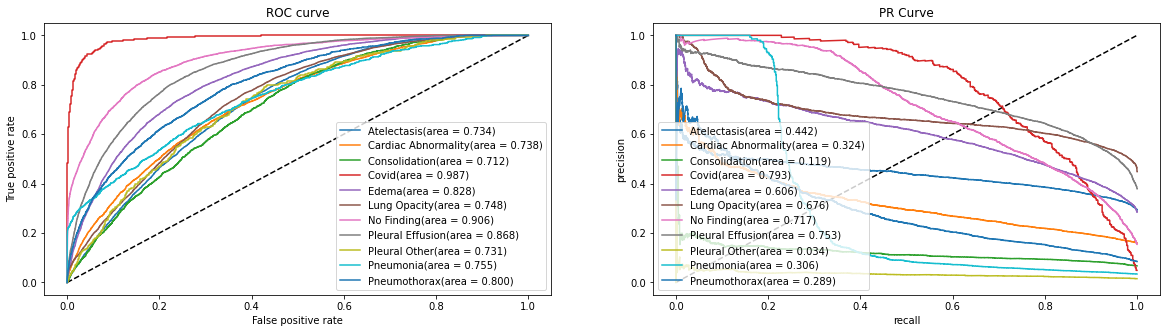

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn

f, ax = plt.subplots(1, 2, figsize=(20,5))
AUCs = []

ax[0].plot([0, 1], [0, 1], 'k--')

ax[1].plot([0, 1], [0, 1], 'k--')

print(chexphoto_targets)

for ii in range(len(chexphoto_targets)):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels[:,ii], y_pred_keras[:,ii])
    auc_keras = auc(fpr_keras, tpr_keras)
    AUCs.append(auc_keras)
    ax[0].plot(fpr_keras, tpr_keras, label=chexphoto_targets[ii] + '(area = {:.3f})'.format(auc_keras))

ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve')
ax[0].legend(loc='best')
print(sum(AUCs)/len(AUCs))


import sklearn
AUCs = []
for ii in range(len(chexphoto_targets)):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_labels[:, ii], y_pred_keras[:, ii])
    auc_keras = auc(recall, precision)
    AUCs.append(auc_keras)
    ax[1].plot(recall, precision, label=chexphoto_targets[ii] + '(area = {:.3f})'.format(auc_keras))


ax[1].set_xlabel('recall')
ax[1].set_ylabel('precision')
ax[1].set_title('PR Curve')
ax[1].legend(loc='best')
print(sum(AUCs)/len(AUCs))
plt.show()


NameError: name 'roc_curve' is not defined

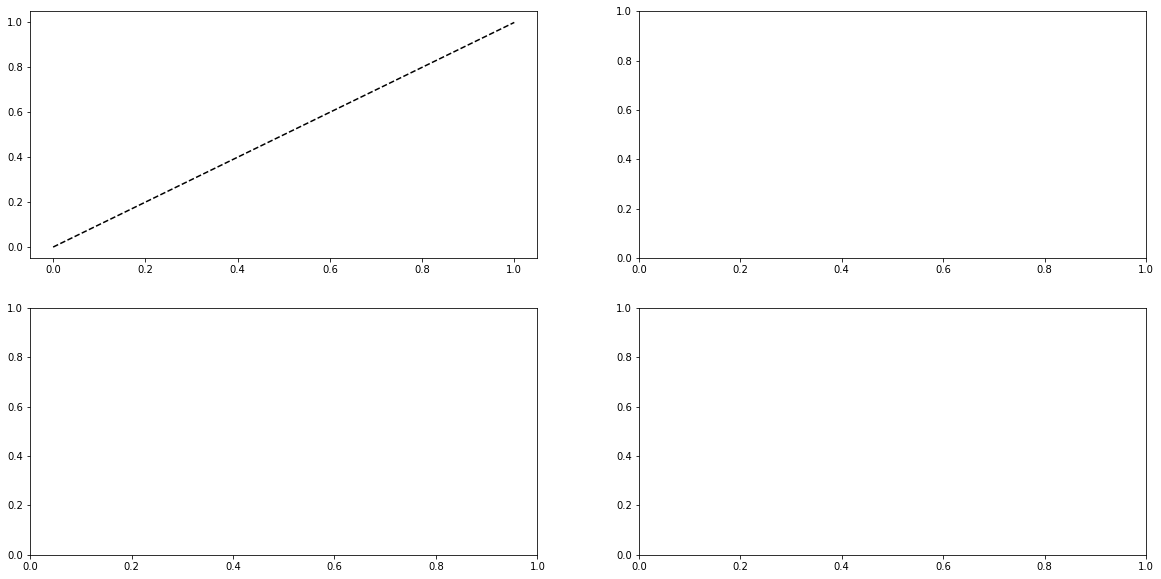

In [3]:
import matplotlib.pyplot as plt
plot_individual_classes = True
if plot_individual_classes:
    f, ax = plt.subplots(2, 2, figsize=(20,10))
    ROC_AUCs = []
    PR_AUCs = []
    thresholds = []
    fprs = []
    tprs = []

    for ii in [0, 1, 2, 3, 4, 5, 6, 7, 8]:#, 4, 5, 6, 7]:#range(0, y_pred_keras.shape[1]):
        ax[ii//2][ii%2].plot([0, 1], [0, 1], 'k--')
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels[:,ii], y_pred_keras[:,ii])
        auc_keras = auc(fpr_keras, tpr_keras)
        ROC_AUCs.append(auc_keras)
        thresholds.append(thresholds_keras)
        fprs.append(fpr_keras)
        tprs.append(tpr_keras)
        ax[ii//2][ii%2].plot(fpr_keras, tpr_keras, label=chexphoto_targets[ii] + '(area = {:.3f})'.format(auc_keras))

        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_labels[:, ii], y_pred_keras[:, ii])
        auc_keras = auc(recall, precision)
        PR_AUCs.append(auc_keras)
        ax[ii//2][ii%2].plot(recall, precision, label=chexphoto_targets[ii] + '(area = {:.3f})'.format(auc_keras))
        ax[ii//2][ii%2].set_title(chexphoto_targets[ii])

    plt.show()

# Setting thresholds and classification reports

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [1]:
# set thresholds
desired_recall = [0.90]*9#, 0.7, 0.67, 0.8, 0.8, 0.8, 0.85, 0.6]
thresh = []
for k in range(len(desired_recall)):
    curr_tpr = tprs[k]
    curr_thresh = thresholds[k]
    for ctr, i in enumerate(curr_tpr):
        if i > desired_recall[k]:
            thresh.append(curr_thresh[ctr])
            break

NameError: name 'tprs' is not defined

In [11]:
from sklearn.metrics import f1_score

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresh = []
for k in range(11):
    thresholds_n = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [f1_score(y_labels[:,k], to_labels(y_pred_keras[:,k], t)) for t in thresholds_n]
    ix = np.argmax(scores)
    thresh.append(thresholds_n[ix])

In [12]:
mean_sen = []
mean_spec = []
for k in range(len(thresh)):
    print(chexphoto_targets[k])
    print("--------------------")
    y_pred = np.copy(y_pred_keras[:, k])
    y_pred[y_pred > thresh[k]] = 1
    y_pred[y_pred != 1] = 0
    tn, fp, fn, tp = confusion_matrix(y_labels[:, k], y_pred).ravel()
    print(f"sensitivity = {tp/(tp+fn)}")
    print(f"specificity = {tn/(tn+fp)}")
#     print(classification_report(y_labels[:, k], y_pred))
    print("------------------------------------------------------------------------------------------")
    mean_sen.append(tp/(tp+fn))
    mean_spec.append(tn/(tn+fp))
    
print(sum(mean_sen)/len(mean_sen))
print(sum(mean_spec)/len(mean_spec))

Atelectasis
--------------------
sensitivity = 0.8109281437125748
specificity = 0.5392711694081557
------------------------------------------------------------------------------------------
Cardiac Abnormality
--------------------
sensitivity = 0.5614371914426769
specificity = 0.7618613554532611
------------------------------------------------------------------------------------------
Consolidation
--------------------
sensitivity = 0.3218314532183145
specificity = 0.8681893687707641
------------------------------------------------------------------------------------------
Covid
--------------------
sensitivity = 0.6771217712177122
specificity = 0.9953284088640447
------------------------------------------------------------------------------------------
Edema
--------------------
sensitivity = 0.7256218525866015
specificity = 0.7698854681096985
------------------------------------------------------------------------------------------
Lung Opacity
--------------------
sensitivity = 0.87

# Plotting client side results 

In [44]:
classifier_8.build_model(load_previous_weights=False, if_grad=True)
try:
    classifier_8.model.load_weights(load_path)
    print('\n\nWeights successfuly loaded\n\n')
    #classifier_8.test_generator.reset()
    #y_pred_keras = classifier_8.model.predict_generator(classifier_8.test_generator,verbose = 1,steps=classifier_8.test_generator.n/classifier_8.test_generator.batch_size)
    #np.save("../predictions/"+load_path.split('/')[-1][:-5]+".npy", y_pred_keras)
except:
    print('Weights not loaded')
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 113, 113, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 113, 113, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 56, 56, 64)   0         

In [45]:
classifier_8.model.output

[<tf.Tensor 'relu_conv10/Relu_1:0' shape=(None, 13, 13, 256) dtype=float32>,
 <tf.Tensor 'loss/Softmax_1:0' shape=(None, 4) dtype=float32>]

In [46]:
def getCamMask(image, cam, thrshld=0.70):
    h, w, ch = image.shape
    maskCam = np.zeros((h, w))
    maskCam[cam > thrshld * np.max(cam)] = 1.0
    return maskCam

def getFirstNblobs(label, ntop=1):
    '''
    Tis function extract first N blobs with largest area from the given mask
    :param label:
    :param ntop:
    :return:
    '''
    N = np.max(label) + 1
    if ntop == None:
        ntop = N
    areas = np.zeros((N, 1))
    for k in range(0, N):
        areas[k] = np.sum(label == (k + 1))
    indx_sorted = np.flipud(np.argsort(areas, axis=0))
    label_indx = []
    if N >= ntop:
        for k in range(0, ntop):
            if areas[indx_sorted[k]] > 0:
                label_indx.append(indx_sorted[k] + 1)
    label_out = np.zeros(label.shape)
    for k in label_indx:
        label_out[label == k] = 1
    return label_out

def getAnnotatedImage(img, mask, ntop=2):
    '''
    This function takes image and mask of shape (m, n) and returns (m, n, 3) annotated image
    :param img:
    :param mask:
    :return:
    '''
    imgAnno = np.copy(img / np.max(img) * 255).astype('int')
    #imgAnno = np.expand_dims(imgAnno, -1)
    #imgAnno = np.concatenate((imgAnno, imgAnno, imgAnno), axis=-1)
    maskLabel = label(mask)
    maskLabel = getFirstNblobs(maskLabel, ntop=ntop)
    maskNew = np.zeros(maskLabel.shape)
    maskNew[maskLabel > 0.0] = 1.0
    contours = find_contours(maskLabel, 0.8)
    for n, contour in enumerate(contours):
        x, y = np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')
        imgAnno[x, y, :] = np.array([255, 0, 0], dtype='int')
    return imgAnno.astype(np.uint8), maskNew

In [ ]:
from IPython.display import clear_output
from skimage import filters
from skimage.measure import label, find_contours
import tensorflow as tf
chexphoto_targets = ["Covid", "Normal", 'Opacity', 'Pneumonia']
def plotImageGroup(randomIndices):
    f,ax = plt.subplots(2, 5, figsize=(20, 10))
    for ctr, k in enumerate(randomIndices):
        ax[ctr//5][ctr%5].imshow(classifier_8.test_generator[k//64][0][k%64])
    plt.show()
    return f

def get_top3(arr):
    return arr.argsort()[-3:][::-1]
    
    
randomIndices = np.random.randint(0, 541, 7)#[1001, 1002, 303, 404, 505, 606, 707]#_2indices + _1indices[0:1]
inds = [0, 1, 2, 3, 4, 5, 6]#, 7, 8, 9]
# f, ax = plt.subplots(5, 2, figsize=(16, 32))

for ctr, index in enumerate(inds):
    x = classifier_8.validation_generator[randomIndices[index]//256][0][randomIndices[index]%256]
    CAT_CLASS_INDEX = [0, 1, 2, 3]#[np.argmax(y_pred_keras[index])]#, 6, 7]
    cams = []
    for class_ind in CAT_CLASS_INDEX:
        with tf.GradientTape() as tape:
            conv_outputs, predictions = classifier_8.model(np.expand_dims(x, axis=0))
            loss = predictions[:, class_ind]

        output = conv_outputs[0]
        grads = tape.gradient(loss, conv_outputs)[0]
        

        gate_f = tf.cast(output > 0, 'float32')
        gate_r = tf.cast(grads > 0, 'float32')
        guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

        weights = tf.reduce_mean(guided_grads, axis=(0, 1))

        cam = np.zeros(output.shape[0: 2], dtype = np.float32)
        
        for i, w in enumerate(weights):
            cam += w * output[:, :, i]    

        cams.append(cam)
        print("%s classes extracted"%class_ind, end="\r", flush=True)
    
    predictions = predictions.numpy()[0]
    top3 = get_top3(predictions)
    top3 = predictions[top3]
    print(top3)
    print("Pred = " + str(chexphoto_targets[np.argmax(predictions)]) + "  with  " +
          "{:0.3f}".format(float(predictions[np.argmax(predictions)])))
    print("GT = " + str(chexphoto_targets[np.argmax(y_labels[randomIndices[index]])]))
    cam_mean = np.array(cams)
    cam = np.mean(cam_mean, axis=0)
    cam = cv2.resize(cam, (227, 227))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)


    img = x
    #img = np.uint8(img)
    #f,ax = plt.subplots(2, 4, figsize=(20, 10))

    camMask = getCamMask(img, heatmap)#filters.gaussian(heatmap, sigma=3))
    imgAnno, maskCam = getAnnotatedImage(img, camMask , ntop=None)
    
    fig = plt.figure(figsize=(4,4))
    plt.imshow(imgAnno)
    plt.imshow(heatmap, alpha=0.4)
#     for m in [chexphoto_targets[np.argmax(predictions)]]:
#         print(y_pred_keras[randomIndices[index]])
#         if m != 'Other' and y_pred_keras[randomIndices[index], chexphoto_targets.index(m)] > 0.65:
#             if m == 'No Finding':
#                 m = 'Healthy'
#                 m_f = 'No Finding'
#             else:
#                 m_f = m
#             plt.plot(0, 0, label=m+'({:0.1f}%)'.format(y_pred_keras[randomIndices[index], chexphoto_targets.index(m_f)]*100))
#     plt.legend(loc='best')
    plt.show()
    print("\n\n")
    
    #fig.savefig('./'+patient+'_'+str(index)+'.jpg', dpi = 100)

#     #fig, ax = plt.subplots(figsize=(7, 7))
#     ax[ctr//2][ctr%2].imshow(imgAnno)
#     ax[ctr//2][ctr%2].imshow(heatmap_mean, alpha=0.4)
#     for m in tps[randomIndices[index]]:
#         if m != 'Other' and y_pred_keras[randomIndices[index], chexphoto_targets.index(m)] > 0.65:
#             if m == 'No Finding':
#                 m = 'Healthy'
#                 m_f = 'No Finding'
#             else:
#                 m_f = m
#             ax[ctr//2][ctr%2].plot(0, 0, label=m+'({:0.1f}%)'.format(y_pred_keras[randomIndices[index], chexphoto_targets.index(m_f)]*100))
#     ax[ctr//2][ctr%2].legend(loc='best')

# plt.show()
    

# Random stuff

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


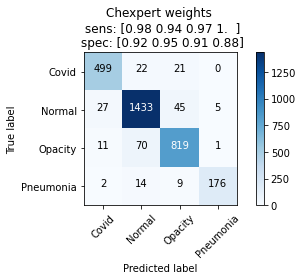

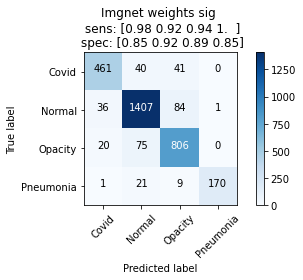

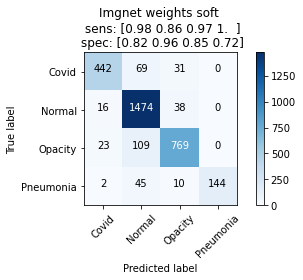

In [42]:
def return_metrics(cnf_matrix_chex):
    FP = cnf_matrix_chex.sum(axis=0) - np.diag(cnf_matrix_chex) 
    FN = cnf_matrix_chex.sum(axis=1) - np.diag(cnf_matrix_chex)
    TP = np.diag(cnf_matrix_chex)
    TN = cnf_matrix_chex.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return TPR, TNR




cnf_matrix_chex = np.array([[ 499, 22,   21,    0],
 [  27, 1433,   45, 5],
 [  11,   70 , 819,    1],
 [   2,   14,    9,  176]])

cnf_matrix_sig_imgnet= np.array([[ 461 ,  40  , 41 ,   0],
 [  36, 1407,   84 ,   1],
 [  20 ,  75,  806  ,  0],
 [   1 ,  21 ,   9  ,170]])

cnf_matrix_soft_imgnet = np.array([[ 442 ,  69,   31,    0],
 [  16 ,1474  , 38  ,  0],
 [  23 , 109  ,769 ,   0],
 [   2 ,  45  , 10 , 144]])



plt.figure()
spec, sens = return_metrics(cnf_matrix_chex)
plot_confusion_matrix(cnf_matrix_chex, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Chexpert weights \n sens: ' + str(sens) + "\n spec: " + str(spec))
plt.figure()
spec, sens = return_metrics(cnf_matrix_sig_imgnet)
plot_confusion_matrix(cnf_matrix_sig_imgnet, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Imgnet weights sig \n sens: ' + str(sens) + "\n spec: " + str(spec))
plt.figure()
spec, sens = return_metrics(cnf_matrix_soft_imgnet)
plot_confusion_matrix(cnf_matrix_soft_imgnet, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Imgnet weights soft \n sens: ' + str(sens) + "\n spec: " + str(spec))



In [49]:
## Chexpert Weights
                precision    recall  f1-score   support

           0       0.93      0.92      0.92       542
           1       0.93      0.95      0.94      1510
           2       0.92      0.91      0.91       901
           3       0.97      0.88      0.92       201

    accuracy                           0.93      3154
   macro avg       0.94      0.91      0.92      3154
weighted avg       0.93      0.93      0.93      3154


Counter({'Other': 19388,
         'Pleural Effusion': 12733,
         'Atelectasis': 9819,
         'Edema': 9817,
         'Cardiomegaly': 4040,
         'No Finding': 3009,
         'Consolidation': 2077,
         'Pneumonia': 809})

Confusion matrix, without normalization
[[ 499   22   21    0]
 [  27 1433   45    5]
 [  11   70  819    1]
 [   2   14    9  176]]


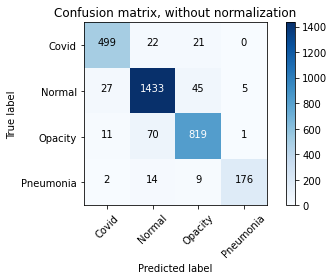

In [6]:
## Chexpert Weights

cnf_matrix = np.array([[ 499, 22,   21,    0],
 [  27, 1433,   45, 5],
 [  11,   70 , 819,    1],
 [   2,   14,    9,  176]])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Confusion matrix, without normalization')

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       542
           1       0.91      0.92      0.92      1528
           2       0.86      0.89      0.88       901
           3       0.99      0.85      0.91       201

    accuracy                           0.90      3172
   macro avg       0.91      0.88      0.89      3172
weighted avg       0.90      0.90      0.90      3172

Confusion matrix, without normalization
[[ 461   40   41    0]
 [  36 1407   84    1]
 [  20   75  806    0]
 [   1   21    9  170]]


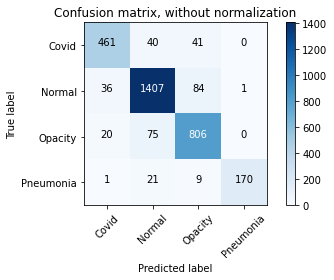

In [17]:
## Simoid Imagenet

cnf_matrix = confusion_matrix(np.array(y_t), np.array(y_p))#, labels=["Covid", "Normal", 'Opacity', 'Pneumonia'], binary=False)

print(classification_report(np.array(y_t), np.array(y_p)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Confusion matrix, without normalization')


              precision    recall  f1-score   support

           0       0.92      0.82      0.86       542
           1       0.87      0.96      0.91      1528
           2       0.91      0.85      0.88       901
           3       1.00      0.72      0.83       201

    accuracy                           0.89      3172
   macro avg       0.92      0.84      0.87      3172
weighted avg       0.90      0.89      0.89      3172

Confusion matrix, without normalization
[[ 442   69   31    0]
 [  16 1474   38    0]
 [  23  109  769    0]
 [   2   45   10  144]]


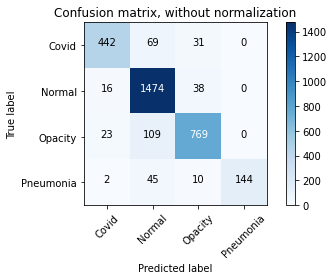

In [19]:
## Softmax Imagenet

cnf_matrix = confusion_matrix(np.array(y_t), np.array(y_p))#, labels=["Covid", "Normal", 'Opacity', 'Pneumonia'], binary=False)

print(classification_report(np.array(y_t), np.array(y_p)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Covid", "Normal", 'Opacity', 'Pneumonia'],
                      title='Confusion matrix, without normalization')